In [1]:
import os
import pathlib
from typing import Union
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Any

In [2]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Input, Sequential
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception, EfficientNetB3, InceptionV3, EfficientNetB5, VGG16

In [3]:
tf.random.set_seed(32167)

In [4]:
def plot_loss_curves(history: Any) -> None:
    """
    Plots the curves of both loss and accuracy using Seaborn with improved formatting and annotated values
    
    Args:
    - history (Any): History object returned by model.fit()
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(loss))

    # Set Seaborn style with dashed grid lines for specific intervals on y-axis
    sns.set_style("whitegrid", {'grid.linestyle': '--'})

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Plotting loss
    sns.lineplot(x=epochs, y=loss, label='Training Loss', ax=axes[0], linewidth=2, color='blue')
    sns.lineplot(x=epochs, y=val_loss, label='Validation Loss', ax=axes[0], linewidth=2, color='orange')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylim(0, 1.05)  # Set y-axis limits from 0 to 1.05
    axes[0].set_yticks([i * 0.2 for i in range(6)])  # Set y-axis ticks at 0.2 intervals
    axes[0].legend()

    for i in range(0, len(loss), 3):  # Annotate every 3rd epoch for training loss
        axes[0].annotate(f'{loss[i]:.2f}', (i, loss[i]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
    for i in range(0, len(val_loss), 3):  # Annotate every 3rd epoch for validation loss
        axes[0].annotate(f'{val_loss[i]:.2f}', (i, val_loss[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontweight='bold')

    # Plotting accuracy
    sns.lineplot(x=epochs, y=accuracy, label='Training Accuracy', ax=axes[1], linewidth=2, color='blue')
    sns.lineplot(x=epochs, y=val_accuracy, label='Validation Accuracy', ax=axes[1], linewidth=2, color='orange')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylim(0, 1.05)  # Set y-axis limits from 0 to 1.05
    axes[1].set_yticks([i * 0.2 for i in range(6)])  # Set y-axis ticks at 0.2 intervals
    axes[1].legend()

    for i in range(0, len(accuracy), 3):  # Annotate every 3rd epoch for training accuracy
        axes[1].annotate(f'{accuracy[i]:.2f}', (i, accuracy[i]), textcoords="offset points", xytext=(0,10), ha='center', fontweight='bold')
    for i in range(0, len(val_accuracy), 3):  # Annotate every 3rd epoch for validation accuracy
        axes[1].annotate(f'{val_accuracy[i]:.2f}', (i, val_accuracy[i]), textcoords="offset points", xytext=(0,-15), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()


In [5]:
def create_tensorboard_callback(dir_name: str, experiment_name: str) -> tf.keras.callbacks.TensorBoard:
    """
    Creates a TensorBoard callback instance to store log files.

    Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

    Args:
    - dir_name (str): target directory to store TensorBoard log files
    - experiment_name (str): name of experiment directory (e.g. efficientnet_model_1)
    
    Returns:
    - tensorboard_callback (tf.keras.callbacks.TensorBoard): TensorBoard callback instance
    """
    log_dir = f"{dir_name}/{experiment_name}/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"Saving TensorBoard log files to: {log_dir}")
    return tensorboard_callback

In [6]:
# Get the current date and time
timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
timestamp

'2024-01-06_22-44-37'

In [7]:
models_path = pathlib.Path(r"C:\Users\KonuTech\machine-learning-zoomcamp-capstone-02\models")

#### Prepare training and validation data sets

In [8]:
data_path = pathlib.Path(r"C:\Users\KonuTech\machine-learning-zoomcamp-capstone-02\data\pizza_not_pizza")
class_names = [item.name for item in data_path.glob('*')]
print(class_names)

['not_pizza', 'pizza']


In [9]:
data_gen = ImageDataGenerator(
    rescale = 1/255.,
    validation_split = 0.2
)

In [10]:
training_data = data_gen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'training',
    class_mode = 'binary'
)

Found 1574 images belonging to 2 classes.


In [11]:
validation_data = data_gen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'validation',
    class_mode = 'binary'
)

Found 392 images belonging to 2 classes.


#### Create checkpoint callback

In [12]:
checkpoint_path = "pizza_classification_checkpoint"
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=True
)

In [13]:
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
)

In [14]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

#### Model 1

In [15]:
model_1 = Sequential([
    Input(shape = (224, 224, 3)), # Input layer    
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # First Convolutional layer
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'), # Second Convolutional layer
    Flatten(),
    Dense(1, activation = 'sigmoid') # Output layer  
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 223, 223, 32)      416       
                                                                 
 conv2d_1 (Conv2D)           (None, 222, 222, 32)      4128      
                                                                 
 flatten (Flatten)           (None, 1577088)           0         
                                                                 
 dense (Dense)               (None, 1)                 1577089   
                                                                 
Total params: 1,581,633
Trainable params: 1,581,633
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_1.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

history = model_1.fit(
    training_data,
    epochs= 5,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-224437
Epoch 1/5
50/50 [==============================] - 36s 706ms/step - loss: 2.4558 - accuracy: 0.5273 - val_loss: 0.6895 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 2/5
50/50 [==============================] - 34s 674ms/step - loss: 0.6339 - accuracy: 0.6741 - val_loss: 0.5984 - val_accuracy: 0.6939 - lr: 0.0010
Epoch 3/5
50/50 [==============================] - 33s 653ms/step - loss: 0.5011 - accuracy: 0.7903 - val_loss: 0.6086 - val_accuracy: 0.6582 - lr: 0.0010
Epoch 4/5
50/50 [==============================] - 33s 654ms/step - loss: 0.2467 - accuracy: 0.9288 - val_loss: 0.6307 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 5/5
50/50 [==============================] - 33s 658ms/step - loss: 0.0834 - accuracy: 0.9828 - val_loss: 0.6594 - val_accuracy: 0.6939 - lr: 0.0010


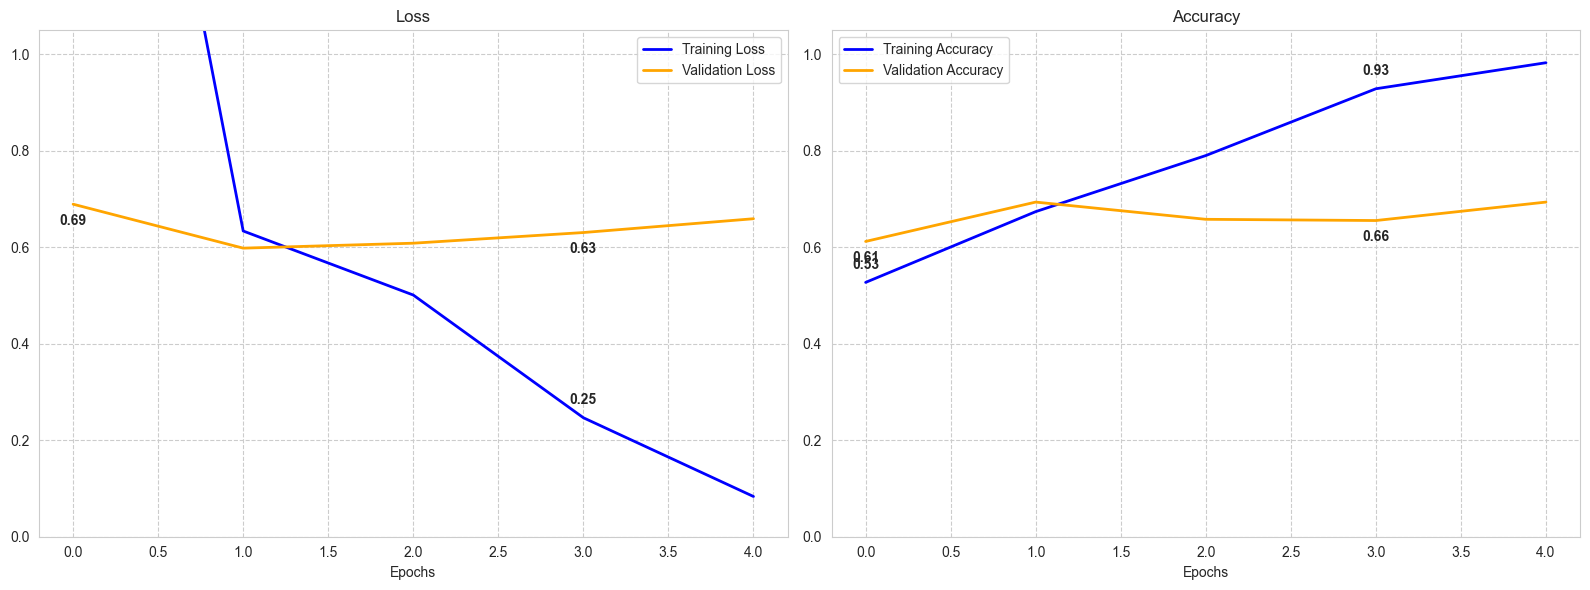

In [17]:
plot_loss_curves(history)

#### Model 2

In [18]:
model_2 = Sequential(
    [
        Input(shape = (224, 224, 3)),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2), # It will reduce the number of features by half
        Conv2D(filters = 32, kernel_size =2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ]
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 96800)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [19]:
model_2.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

history = model_1.fit(
    training_data,
    epochs= 5,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-224726
Epoch 1/5
50/50 [==============================] - 35s 693ms/step - loss: 0.0248 - accuracy: 0.9994 - val_loss: 0.6698 - val_accuracy: 0.6862 - lr: 2.0000e-04
Epoch 2/5
50/50 [==============================] - 33s 665ms/step - loss: 0.0176 - accuracy: 0.9994 - val_loss: 0.7055 - val_accuracy: 0.6862 - lr: 2.0000e-04
Epoch 3/5
50/50 [==============================] - 34s 691ms/step - loss: 0.0132 - accuracy: 1.0000 - val_loss: 0.6863 - val_accuracy: 0.6760 - lr: 2.0000e-04
Epoch 4/5
50/50 [==============================] - 34s 677ms/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.6878 - val_accuracy: 0.6964 - lr: 2.0000e-04
Epoch 5/5
50/50 [==============================] - 33s 651ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.6891 - val_accuracy: 0.6939 - lr: 4.0000e-05


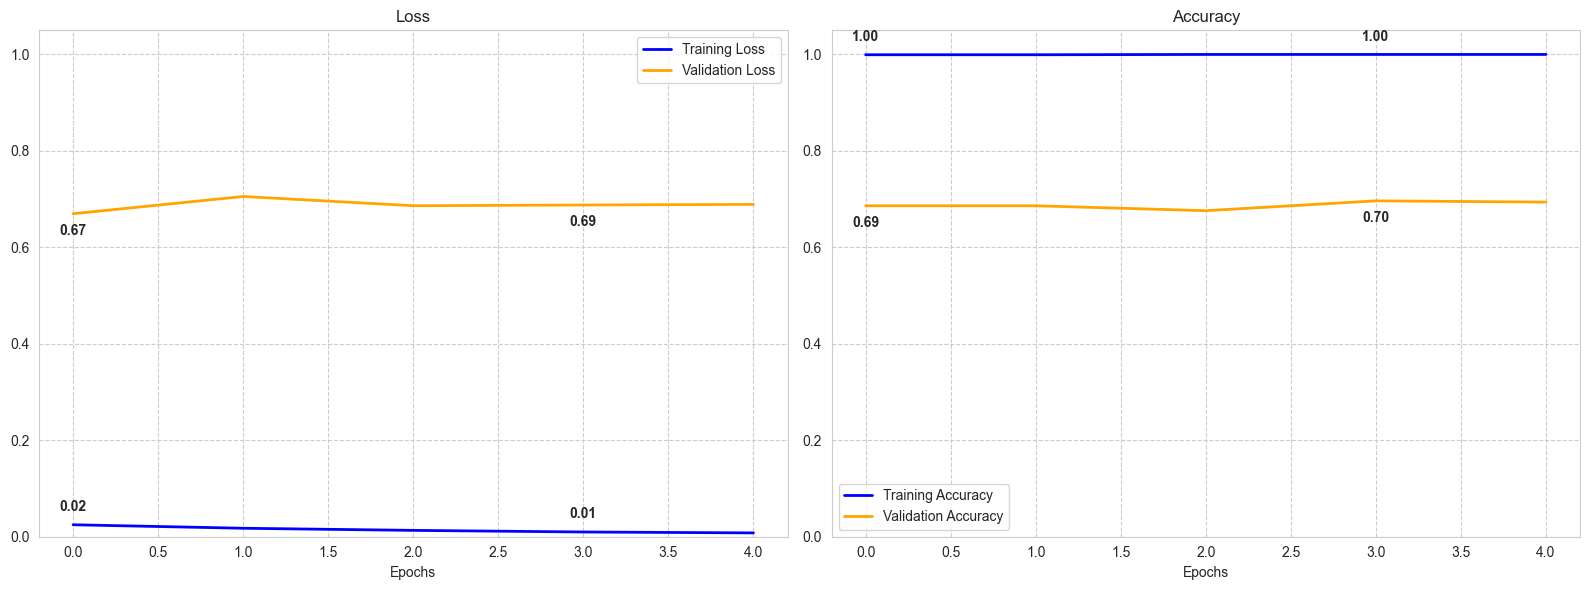

In [20]:
plot_loss_curves(history)

#### Model 3

In [21]:
augmentations = dict(
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=None,
    shear_range=0.1,
    zoom_range=0.1,
    channel_shift_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [22]:
data_gen_augmented = ImageDataGenerator(
    rescale = 1/255.,
    validation_split = 0.2,
    **augmentations
)

In [23]:
# augmented Trining data
training_data_augmented = data_gen_augmented.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'training',class_mode = 'binary'
)

Found 1574 images belonging to 2 classes.


In [24]:
# non augmented Validation data
val_data = data_gen.flow_from_directory(
    data_path,
    target_size = (224, 224),
    batch_size = 32,
    subset = 'validation',
    class_mode = 'binary'
)

Found 392 images belonging to 2 classes.


In [25]:
model_3 = Sequential(
    [
        Input(shape = (224, 224, 3)),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ]
)

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 110, 110, 32)      4128      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 96800)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                

In [26]:
model_3.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(),
    metrics = ['accuracy']
)

In [27]:
history = model_3.fit(
    training_data_augmented, # changing the training data
    epochs= 5,
    steps_per_epoch = len(training_data_augmented),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-225016
Epoch 1/5
50/50 [==============================] - 31s 616ms/step - loss: 0.8794 - accuracy: 0.5629 - val_loss: 0.6383 - val_accuracy: 0.6301 - lr: 0.0010
Epoch 2/5
50/50 [==============================] - 32s 630ms/step - loss: 0.6252 - accuracy: 0.6518 - val_loss: 0.5596 - val_accuracy: 0.7423 - lr: 0.0010
Epoch 3/5
50/50 [==============================] - 31s 613ms/step - loss: 0.5875 - accuracy: 0.6944 - val_loss: 0.5258 - val_accuracy: 0.7704 - lr: 0.0010
Epoch 4/5
50/50 [==============================] - 30s 603ms/step - loss: 0.5665 - accuracy: 0.7058 - val_loss: 0.5528 - val_accuracy: 0.7194 - lr: 0.0010
Epoch 5/5
50/50 [==============================] - 32s 635ms/step - loss: 0.5589 - accuracy: 0.7192 - val_loss: 0.5492 - val_accuracy: 0.7372 - lr: 0.0010


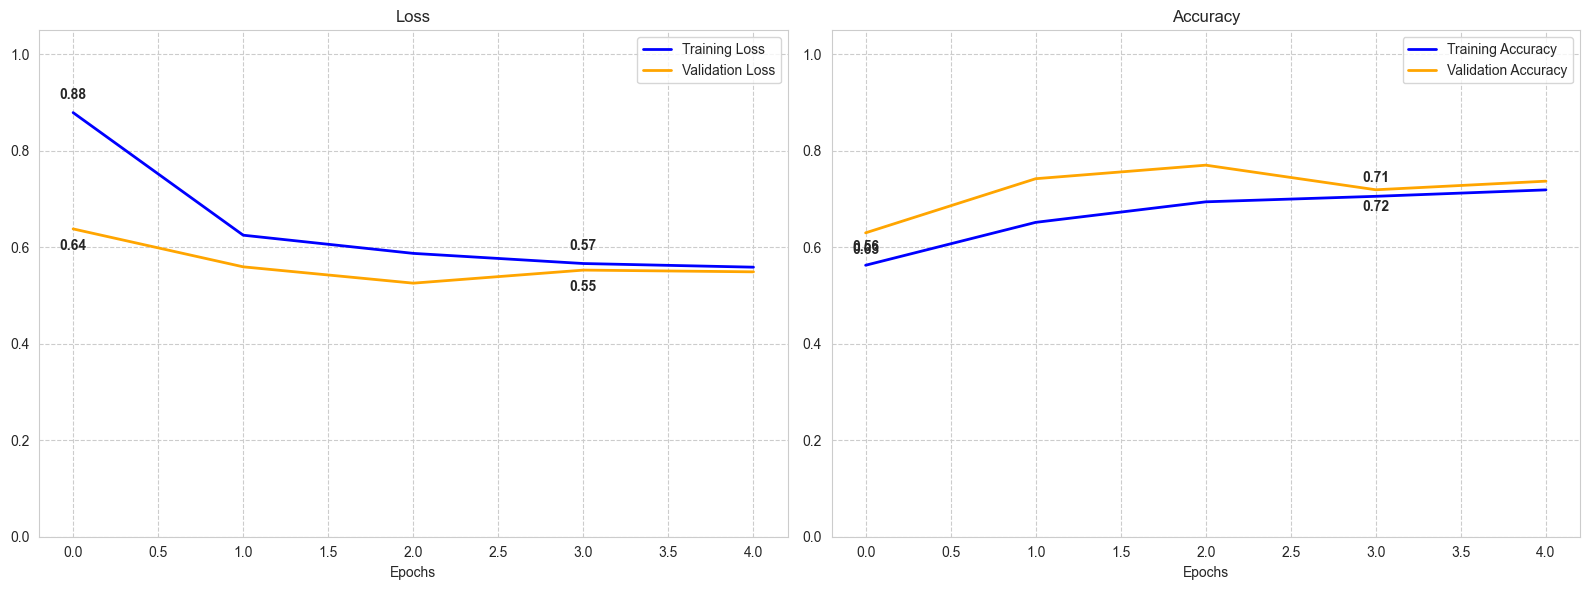

In [28]:
plot_loss_curves(history)

#### Model 4

In [29]:
model_4 = Sequential(
    [
        Input(shape = (224, 224, 3)),
        Conv2D(filters = 10, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Conv2D(filters = 64, kernel_size = 2, padding = 'valid', activation = 'relu'),
        MaxPool2D(pool_size = 2),
        Flatten(),
        Dense(1, activation = 'sigmoid')
    ]
)

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 223, 223, 10)      130       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 10)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 110, 110, 32)      1312      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 55, 55, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 54, 54, 64)        8256      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 27, 27, 64)      

In [30]:
model_4.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [31]:
history = model_4.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-225253
Epoch 1/20
50/50 [==============================] - 15s 286ms/step - loss: 0.6800 - accuracy: 0.5699 - val_loss: 0.6112 - val_accuracy: 0.7092 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 15s 289ms/step - loss: 0.5869 - accuracy: 0.6970 - val_loss: 0.5302 - val_accuracy: 0.7857 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 14s 288ms/step - loss: 0.5356 - accuracy: 0.7478 - val_loss: 0.5428 - val_accuracy: 0.7602 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 13s 268ms/step - loss: 0.4615 - accuracy: 0.7935 - val_loss: 0.5402 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 13s 264ms/step - loss: 0.3955 - accuracy: 0.8361 - val_loss: 0.5362 - val_accuracy: 0.7474 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 13s 262ms/step - loss: 0.3069 - accuracy: 0.8875 - val_loss: 0.5224 - val_accuracy: 

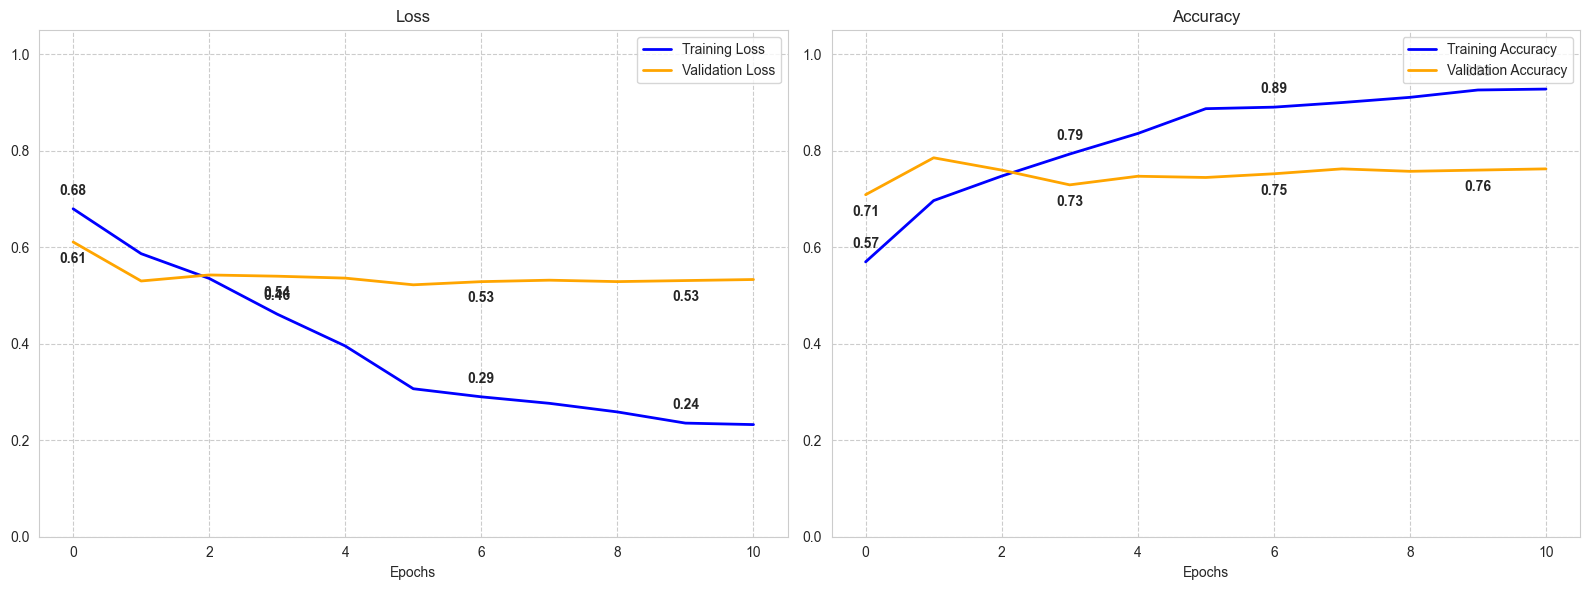

In [32]:
plot_loss_curves(history)

#### Model 5

In [60]:
# Load pre-trained Xception model without the top (fully connected layers)
base_model_xception = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the layers in the base Xception model
base_model_xception.trainable = False

In [61]:
model_xception = Sequential([
    base_model_xception,
    GlobalAveragePooling2D(),
    Dense(1, activation='sigmoid')
])

model_xception.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [62]:
model_xception.compile(
    loss = BinaryCrossentropy(),
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [63]:
history = model_xception.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240107-011438
Epoch 1/20


c:\users\konutech\machine-learning-zoomcamp-capstone-02\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


50/50 [==============================] - 86s 2s/step - loss: 0.2348 - accuracy: 0.9327 - val_loss: 0.1488 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 81s 2s/step - loss: 0.1267 - accuracy: 0.9536 - val_loss: 0.1418 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 86s 2s/step - loss: 0.1116 - accuracy: 0.9549 - val_loss: 0.1310 - val_accuracy: 0.9541 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 82s 2s/step - loss: 0.1035 - accuracy: 0.9587 - val_loss: 0.1343 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 82s 2s/step - loss: 0.0948 - accuracy: 0.9625 - val_loss: 0.1302 - val_accuracy: 0.9515 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 82s 2s/step - loss: 0.0921 - accuracy: 0.9632 - val_loss: 0.1525 - val_accuracy: 0.9311 - lr: 0.0010
Epoch 7/20
50/50 [==============================] - 81s 2s/step - loss: 0.0870 - accuracy: 0.

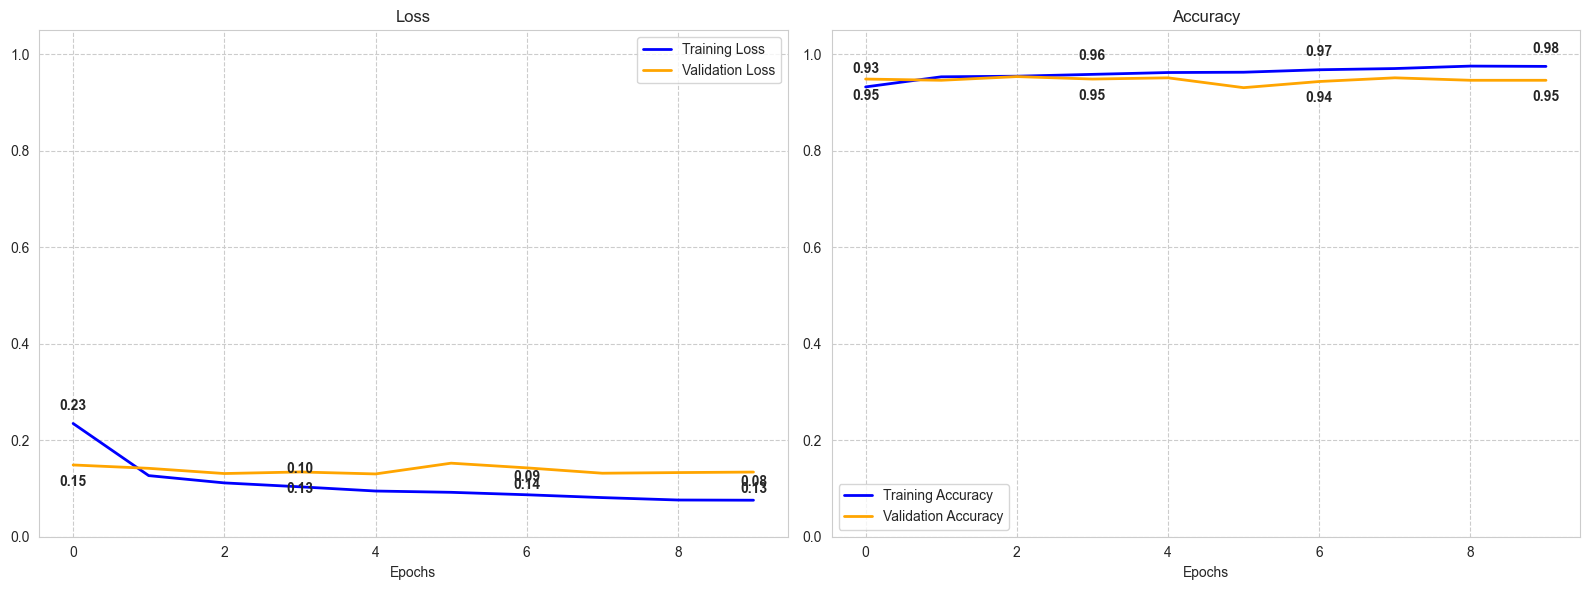

In [64]:
plot_loss_curves(history)

#### Model 6

In [38]:
base_model_efficientnet = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet.trainable = False

In [39]:
model_efficientnet = Sequential([
    base_model_efficientnet,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_efficientnet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 7, 7, 1536)       10783535  
                                                                 
 flatten_4 (Flatten)         (None, 75264)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 75265     
                                                                 
Total params: 10,858,800
Trainable params: 75,265
Non-trainable params: 10,783,535
_________________________________________________________________


In [40]:
model_efficientnet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [41]:
history = model_efficientnet.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-231153


c:\users\konutech\machine-learning-zoomcamp-capstone-02\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
50/50 [==============================] - 102s 2s/step - loss: 1.4589 - accuracy: 0.5019 - val_loss: 0.6896 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 91s 2s/step - loss: 0.8543 - accuracy: 0.5184 - val_loss: 1.0009 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 100s 2s/step - loss: 1.3101 - accuracy: 0.4924 - val_loss: 0.7299 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 94s 2s/step - loss: 0.9420 - accuracy: 0.5013 - val_loss: 0.9895 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 100s 2s/step - loss: 0.7355 - accuracy: 0.5362 - val_loss: 0.6763 - val_accuracy: 0.5944 - lr: 2.0000e-04
Epoch 6/20
50/50 [==============================] - 103s 2s/step - loss: 0.7349 - accuracy: 0.5089 - val_loss: 0.6905 - val_accuracy: 0.5204 - lr: 2.0000e-04
Epoch 7/20
50/50 [==============================] - 102s 2s/step - los

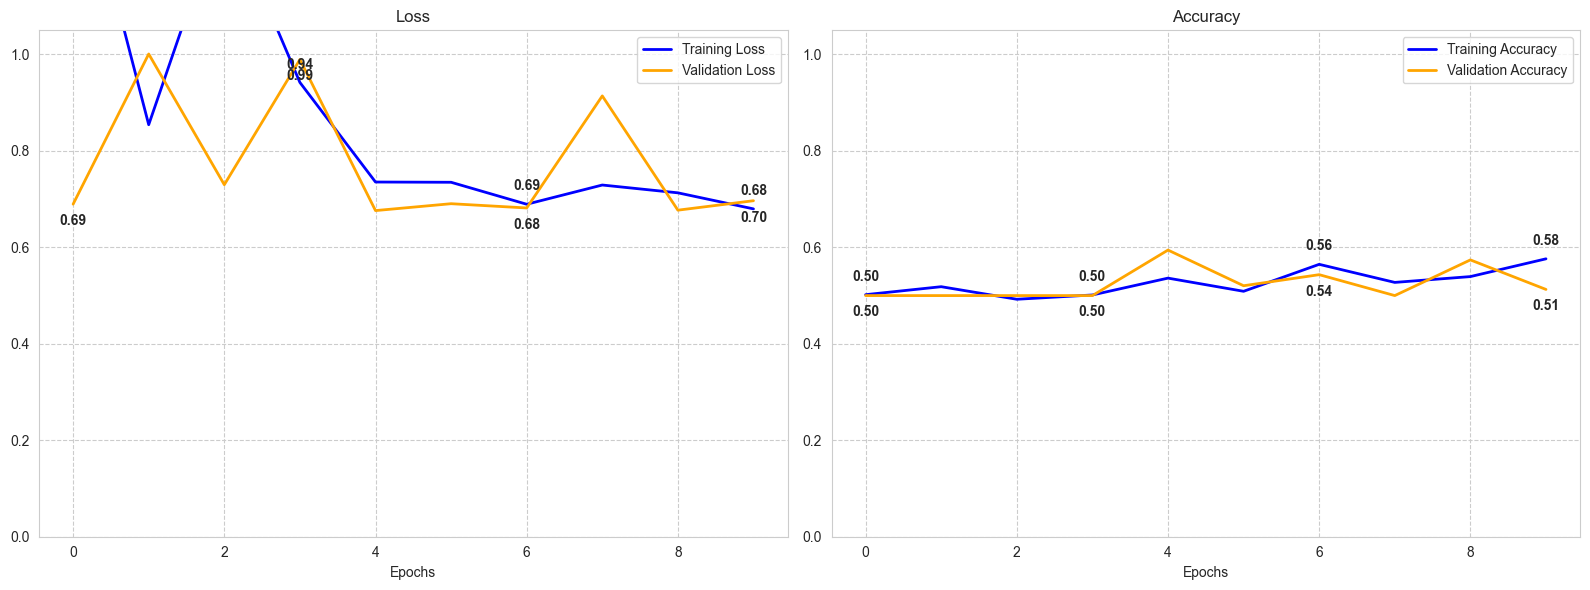

In [42]:
plot_loss_curves(history)

#### Model 7

In [43]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_inception.trainable = False

In [44]:
model_inception = Sequential([
    base_model_inception,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_inception.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51201     
                                                                 
Total params: 21,853,985
Trainable params: 51,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [45]:
model_inception.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
history = model_inception.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-232839
Epoch 1/20
50/50 [==============================] - 59s 1s/step - loss: 1.0378 - accuracy: 0.8837 - val_loss: 0.4045 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 54s 1s/step - loss: 0.1698 - accuracy: 0.9676 - val_loss: 0.2855 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 53s 1s/step - loss: 0.0430 - accuracy: 0.9841 - val_loss: 0.2849 - val_accuracy: 0.9439 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 53s 1s/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.3272 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 50s 1s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.2570 - val_accuracy: 0.9464 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 51s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.2564 - val_accuracy: 0.9464 - lr: 0.001

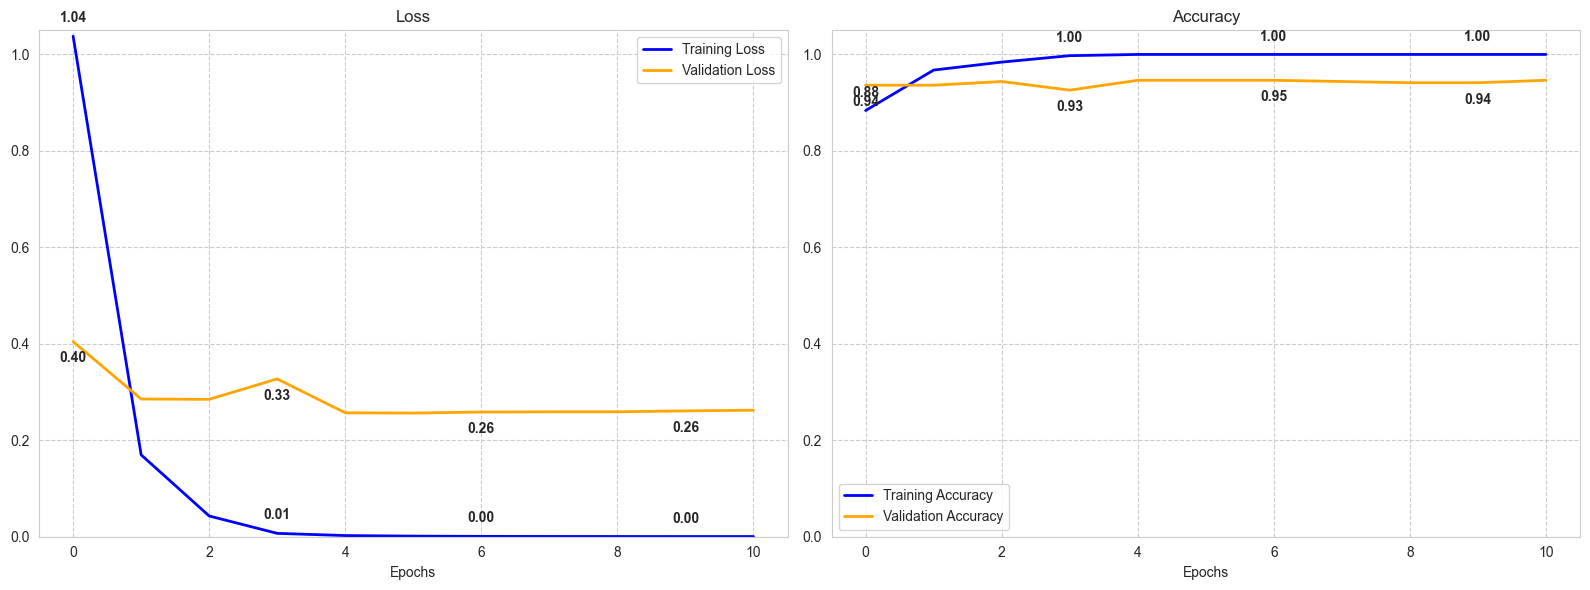

In [47]:
plot_loss_curves(history)

#### Model 8

In [48]:
base_model_efficientnet_b5 = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_efficientnet_b5.trainable = False

In [49]:
model_efficientnet_b5 = Sequential([
    base_model_efficientnet_b5,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_efficientnet_b5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 flatten_6 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 1)                 100353    
                                                                 
Total params: 28,613,880
Trainable params: 100,353
Non-trainable params: 28,513,527
_________________________________________________________________


In [50]:
model_efficientnet_b5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [51]:
history = model_efficientnet_b5.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240106-233834


c:\users\konutech\machine-learning-zoomcamp-capstone-02\venv\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/20
50/50 [==============================] - 205s 4s/step - loss: 5.8439 - accuracy: 0.4917 - val_loss: 5.9419 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 182s 4s/step - loss: 2.9748 - accuracy: 0.5121 - val_loss: 0.7872 - val_accuracy: 0.5026 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 181s 4s/step - loss: 2.0845 - accuracy: 0.4740 - val_loss: 1.0651 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 179s 4s/step - loss: 1.1829 - accuracy: 0.4917 - val_loss: 3.7945 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 172s 3s/step - loss: 2.4132 - accuracy: 0.4892 - val_loss: 0.9979 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 173s 3s/step - loss: 0.8742 - accuracy: 0.4981 - val_loss: 1.2193 - val_accuracy: 0.5000 - lr: 2.0000e-04
Epoch 7/20
50/50 [==============================] - 173s 3s/step - loss:

#### Model 9

In [52]:
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_vgg16.trainable = False

In [53]:
model_vgg16 = Sequential([
    base_model_vgg16,
    Flatten(),
    Dense(1, activation='sigmoid')
])

model_vgg16.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [54]:
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [55]:
history = model_vgg16.fit(
    training_data, # non-augmented training data
    epochs= 20,
    steps_per_epoch = len(training_data),
    validation_data = validation_data,
    validation_steps = len(validation_data),
    callbacks=[
        early_stopping,
        create_tensorboard_callback(
            "training_logs",
            "pizza_classification"
        ),
        checkpoint_callback,
        reduce_lr
    ]
)

Saving TensorBoard log files to: training_logs/pizza_classification/20240107-003102
Epoch 1/20
50/50 [==============================] - 187s 4s/step - loss: 0.4303 - accuracy: 0.8030 - val_loss: 0.2756 - val_accuracy: 0.8852 - lr: 0.0010
Epoch 2/20
50/50 [==============================] - 184s 4s/step - loss: 0.2049 - accuracy: 0.9187 - val_loss: 0.2496 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 3/20
50/50 [==============================] - 179s 4s/step - loss: 0.1397 - accuracy: 0.9600 - val_loss: 0.2517 - val_accuracy: 0.9158 - lr: 0.0010
Epoch 4/20
50/50 [==============================] - 173s 3s/step - loss: 0.0928 - accuracy: 0.9835 - val_loss: 0.2571 - val_accuracy: 0.9082 - lr: 0.0010
Epoch 5/20
50/50 [==============================] - 172s 3s/step - loss: 0.0754 - accuracy: 0.9905 - val_loss: 0.2576 - val_accuracy: 0.9133 - lr: 0.0010
Epoch 6/20
50/50 [==============================] - 172s 3s/step - loss: 0.0523 - accuracy: 0.9987 - val_loss: 0.2238 - val_accuracy: 0.9158 - lr:

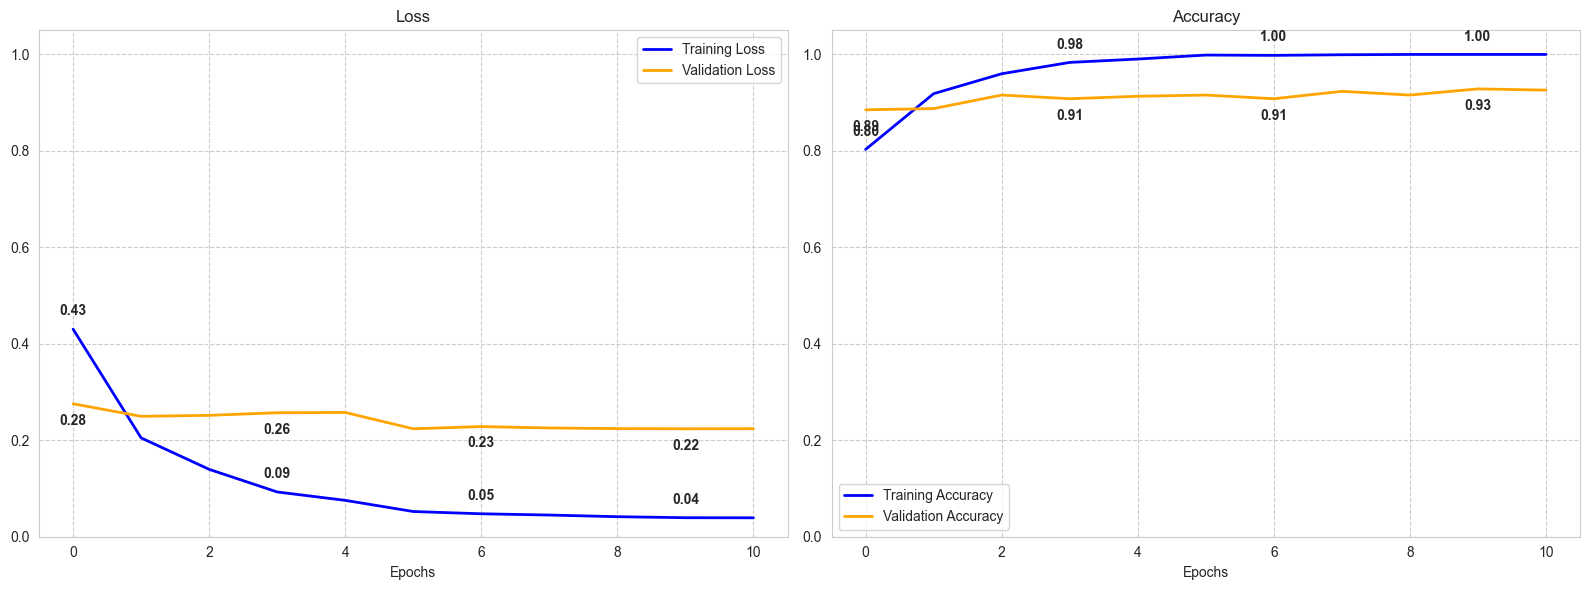

In [56]:
plot_loss_curves(history)

#### Save model inception

In [57]:
model_inception.save(f"{models_path}/model_inception_{timestamp}.keras")

#### Model inception evaluation

In [59]:
training_score = model_inception.evaluate(training_data, verbose= 1)
validation_score = model_inception.evaluate(validation_data, verbose= 1)

print("Validation Loss: ", validation_score[0])
print("Validation Accuracy: ", validation_score[1])

13/13 [==============================] - 9s 687ms/step - loss: 0.2564 - accuracy: 0.9464
Validation Loss:  0.256393700838089
Validation Accuracy:  0.9464285969734192


#### Save model xception

In [67]:
model_xception.save(f"{models_path}/model_xception_{timestamp}.keras")

#### Model xception evaluation

In [68]:
training_score = model_xception.evaluate(training_data, verbose= 1)
validation_score = model_xception.evaluate(validation_data, verbose= 1)

print("Validation Loss: ", validation_score[0])
print("Validation Accuracy: ", validation_score[1])

13/13 [==============================] - 18s 1s/step - loss: 0.1302 - accuracy: 0.9515
Validation Loss:  0.13018791377544403
Validation Accuracy:  0.9515306353569031
